<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/MobileNetV2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications import MobileNetV2
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# **LOADING AND UNZIPPING THE DATASET**

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-16 20:02:24--  https://docs.google.com/uc?export=download&confirm=Ohgv&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.113, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-bc-docs.googleusercontent.com/docs/securesc/4e0vsns5iiruvet1951enl373sb5e07g/2qtkk9mea0rchee1pkkupih2msukcmv8/1589659275000/14211000813324722452/04321481748562599098Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-16 20:02:24--  https://doc-14-bc-docs.googleusercontent.com/docs/securesc/4e0vsns5iiruvet1951enl373sb5e07g/2qtkk9mea0rchee1pkkupih2msukcmv8/1589659275000/14211000813324722452/04321481748562599098Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-14-bc-docs.googleusercontent.com (doc-14-bc-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle

# **SPECIFIYING PATHS TO DIRECTORY**

In [0]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/boots', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/syringes', '/content/split_dataset/train/knives', '/content/split_dataset/train/bottles', '/content/split_dataset/train/bullet_shells']


In [0]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED MobileNetV2**

In [0]:
mobnet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in mobnet.layers:
  layer.trainable = False

In [0]:
x = Flatten()(mobnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE MobileNetV2 MODEL**

In [0]:
model_mobnet = Model(inputs=mobnet.input, outputs=prediction)
model_mobnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
model_mobnet.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [0]:
history_mobnet = model_mobnet.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/50
 17/203 [=>............................] - ETA: 2:13 - loss: 4.8460 - accuracy: 0.5239

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 106s 522ms/step - loss: 1.7817 - accuracy: 0.8286 - val_loss: 7.3700 - val_accuracy: 0.6535
Epoch 2/50
203/203 [==============================] - 96s 471ms/step - loss: 1.6508 - accuracy: 0.8884 - val_loss: 1.8304 - val_accuracy: 0.9009
Epoch 3/50
203/203 [==============================] - 97s 477ms/step - loss: 1.6615 - accuracy: 0.9040 - val_loss: 2.3355 - val_accuracy: 0.8560
Epoch 4/50
203/203 [==============================] - 96s 470ms/step - loss: 1.6148 - accuracy: 0.9156 - val_loss: 1.5395 - val_accuracy: 0.8375
Epoch 5/50
203/203 [==============================] - 97s 476ms/step - loss: 1.6302 - accuracy: 0.9222 - val_loss: 0.8514 - val_accuracy: 0.9120
Epoch 6/50
203/203 [==============================] - 95s 470ms/step - loss: 1.7404 - accuracy: 0.9188 - val_loss: 1.6040 - val_accuracy: 0.9058
Epoch 7/50
203/203 [==============================] - 96s 474ms/step - loss: 1.5300 - accuracy: 0.9318 - val_loss: 3.7669 - val_accuracy: 0.

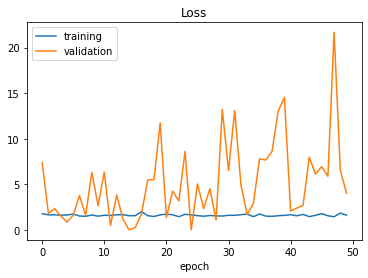

In [0]:
plt.plot(history_mobnet.history['loss'])
plt.plot(history_mobnet.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

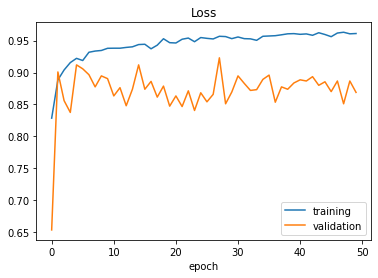

In [0]:
plt.plot(history_mobnet.history['accuracy'])
plt.plot(history_mobnet.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
model_mobnet.save('mobNetV2.h5')

In [0]:
from google.colab import files
files.download('mobNetV2.h5')